   Author: Ankit Kariryaa, University of Bremen

   Licensed under the GNU Affero General Public License v3.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       https://www.gnu.org/licenses/

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.

In [1]:
import numpy as np               # numerical array manipulation
import os
import time
from PIL import Image
import rasterio                  # I/O raster data (netcdf, height, geotiff, ...)
from functools import reduce
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.optimizers import Adam

# from core.frame_info import FrameInfo
from core.split_frames import split_dataset
# from core.dataset_generator import DataGenerator
# from core.UNet import UNet
# from core.losses import tversky_loss, jaccard_distance_loss, dice_coef, dice_loss, true_positive_rate, accuracy
# from core.optimizers import adaDelta, adagrad, adam, nadam

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf; print(tf.__version__)

Using TensorFlow backend.


1.15.2


In [2]:
# Initialize the data related variables used in the notebook
# We use the channel last format

# For reading the ndvi, pan and annotated images generated in the step - 1
base_dir = '../Data/cleanedData/'
image_type = '.png'
image_fn = 'aerialImage'
road_fn = 'extractedRoads'
annotation_fn = 'extractedPolygons'


# For generating fixed size patches, the frames are divided into training and testing frames and proportional number of paches are generated from the two set
patch_generation_stratergy = 'sequential' # 'random' or 'sequential'

# Patch size is height * width * (count (input + output) channels)
patch_size = (256,256,5) #[R,G,B, roadMask, output]
test_ratio = 0.2
val_ratio = 0.2

# # When stratergy == sequential
step_size = (128,128)

patch_dir = '../Data/cleanedData/patches{}'.format(patch_size[0])
frames_json = os.path.join(patch_dir,'frames_list.json')

# It is assumed that the output has only one channel, 
annotation_channel_count = 1 # Count of output/annotation channels 

input_shape = patch_size[:2] + (patch_size[-1] - annotation_channel_count,)  # Notice the "," in the end, it marks the tuple: https://stackoverflow.com/questions/4913397/how-to-add-value-to-a-tuple/4913789
print(input_shape)
# Next we specify the order of channels in the patch, it is assumed that output or label channel goes in the end.
image_channels = list(range(patch_size[-1] - annotation_channel_count)) # Example, list(range(0,2)) -> [0,1] are the input channels 
label_channels = list(range(patch_size[-1] - annotation_channel_count, patch_size[-1])) # Example, list(range(2,3)) -> [2] are the label channels; Channel count is 3 but the channels are [0,1,2] 

print(f'Image channels are {image_channels} and label channels are {label_channels}.')

(256, 256, 4)
Image channels are [0, 1, 2, 3] and label channels are [4].


In [3]:
# Initialize the train related variables used in the notebook
BATCH_SIZE = 8
NB_EPOCHS = 100

# number of validation images to use
VALID_IMG_COUNT = 100
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200


OPTIMIZER = Adam(lr= 5.0e-05, decay= 0.0, beta_1= 0.9, beta_2= 0.999, epsilon= 1.0e-8)
# LOSS = tversky_loss

#Only for the name of the model in the very end
OPTIMIZER_NAME = 'adam'
LOSS_NAME = 'Tversky_loss'

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
# Declare the path to the final model
# If you want to re-train an exising model then change the cell where model is declared. 
# This path is for storing a model after training.

timestr = time.strftime("%Y%m%d-%H%M")
chf = image_channels + label_channels
chs = reduce(lambda a,b: a+str(b), chf, '')

model_path = './saved_models/UNet'
if not os.path.exists(model_path):
    os.makedirs(model_path)
model_path = os.path.join(model_path,'hamburg_{}_{}_{}_{}_{}.h5'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs, input_shape[0]))
print(model_path)
# The weights without the model architecture can also be saved. Just saving the weights is more efficent.

# weight_path="./saved_weights/UNet/{}/".format(timestr)
# if not os.path.exists(weight_path):
#     os.makedirs(weight_path)
# weight_path=weight_path + "{}_weights.best.hdf5".format('UNet_model')
# print(weight_path)

./saved_models/UNet/hamburg_20200512-0934_adam_Tversky_loss_01234_256.h5


In [5]:
class FrameInfo:
    def __init__(self, img, roadNetwork, annotations, dtype=np.float32):
        self.img = img
        self.roadNetwork = np.expand_dims(roadNetwork, axis=-1)
        self.annotations = np.expand_dims(annotations, axis=-1)
        self.dtype = dtype

    # Normalization takes a probability between 0 and 1 that an image will be locally normalized.
    def get_patch(self, i, j, patch_size, max_possible_patch_size):
        patch = np.zeros(patch_size, dtype=self.dtype)
        im = self.img[i:i + max_possible_patch_size[0], j:j + max_possible_patch_size[1]]
        im = im / 255 # Normalize RGB image
        rd = self.roadNetwork[i:i + max_possible_patch_size[0], j:j + max_possible_patch_size[1]]
        an = self.annotations[i:i + max_possible_patch_size[0], j:j + max_possible_patch_size[1]]
        an = rd * an # Only predict where the road is non zero
        comb_img = np.concatenate((im, rd, an), axis=-1)
        patch[:max_possible_patch_size[0], :max_possible_patch_size[1], ] = comb_img
        
        return patch

    # Returns all patches in a image, sequentially generated
    def sequential_patches(self, patch_size, step_size):
        img_shape = self.img.shape
        x = range(0, img_shape[0] - patch_size[0], step_size[0])
        y = range(0, img_shape[1] - patch_size[1], step_size[1])
        if img_shape[0] <= patch_size[0]:
            x = [0]
        if img_shape[1] <= patch_size[1]:
            y = [0]

        max_possible_patch_size = (min(img_shape[0], patch_size[0]), min(img_shape[1], patch_size[1]))
        xy = [(i, j) for i in x for j in y]
        img_patches = []
        for i, j in xy:
            img_patch = self.get_patch(i, j, patch_size, max_possible_patch_size)
            img_patches.append(img_patch)
        # print(len(img_patches))
        return (img_patches)


def all_sequential_patches(image_channels, label_channels, patch_size, step_size, frames):
    ptches = []
    for frame in frames:
        ps = frame.sequential_patches(patch_size, step_size)
        ptches.extend(ps)
    data = np.array(ptches)
    img = data[..., image_channels]
    ann = data[..., label_channels]
    return (img, ann)

In [6]:
# Read all images/frames into memory
# Frame are a combination of image and their corresponding annotation; These are the images extracted from training areas in the last notebook
frames = []

all_files = os.listdir(base_dir)
all_image_files = [fn for fn in all_files if fn.startswith(image_fn) and fn.endswith(image_type)]
print(f"Total images to read: {len(all_image_files)}, eg. {all_image_files[:min(3, len(all_image_files))]} ...")
for i, fn in enumerate(all_image_files):
    img = rasterio.open(os.path.join(base_dir, fn))
    read_img = img.read()
    read_img = np.transpose(read_img, axes=(1,2,0)) #Channel at the end
    road_im = Image.open(os.path.join(base_dir, fn.replace(image_fn,road_fn)))
    roads = np.array(road_im)
    annotation_im = Image.open(os.path.join(base_dir, fn.replace(image_fn,annotation_fn)))
    annotation = np.array(annotation_im)
    f = FrameInfo(read_img, roads, annotation)
    frames.append(f)

print(f"Total frames read: {len(frames)}")

Total images to read: 2, eg. ['aerialImage_0.png', 'aerialImage_1.png'] ...
Total frames read: 2


In [7]:
def display_images(img, cols = 3):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    """
    rows = img.shape[0]
    plt.figure(figsize=(14, 14 * rows // cols))
    for i in range(rows):
        plt.subplot(rows, cols, (i*cols) + 1)
        plt.axis('off')
        plt.imshow(img[i,...,:3])
        plt.subplot(rows, cols, (i*cols) + 2)
        plt.axis('off')
        plt.imshow(img[i,...,3])
        plt.subplot(rows, cols, (i*cols) + 3)
        plt.axis('off')
        plt.imshow(img[i,...,4])
        if cols == 4:
            plt.subplot(rows, cols, (i*cols) + 4)
            plt.axis('off')
            plt.imshow(img[i,...,5])

In [8]:
allPatches = all_sequential_patches(image_channels, label_channels, patch_size, step_size, frames)
print(f'Divided the images into {len(allPatches[0])} sequential patches')

Divided the images into 2888 sequential patches


In [9]:
#Test 
# p = frames[0].get_patch(0,0,(256,256,5),(256,256,5))

In [10]:
training_patches, validation_patches, testing_patches  = split_dataset(allPatches[0], frames_json, patch_dir)
print(f' Further split the data into {len(training_patches)} training, {len(validation_patches)} validation and {len(testing_patches)} testing patches')

Reading train-test split from file
 Further split the data into 1848 training, 462 validation and 578 testing patches


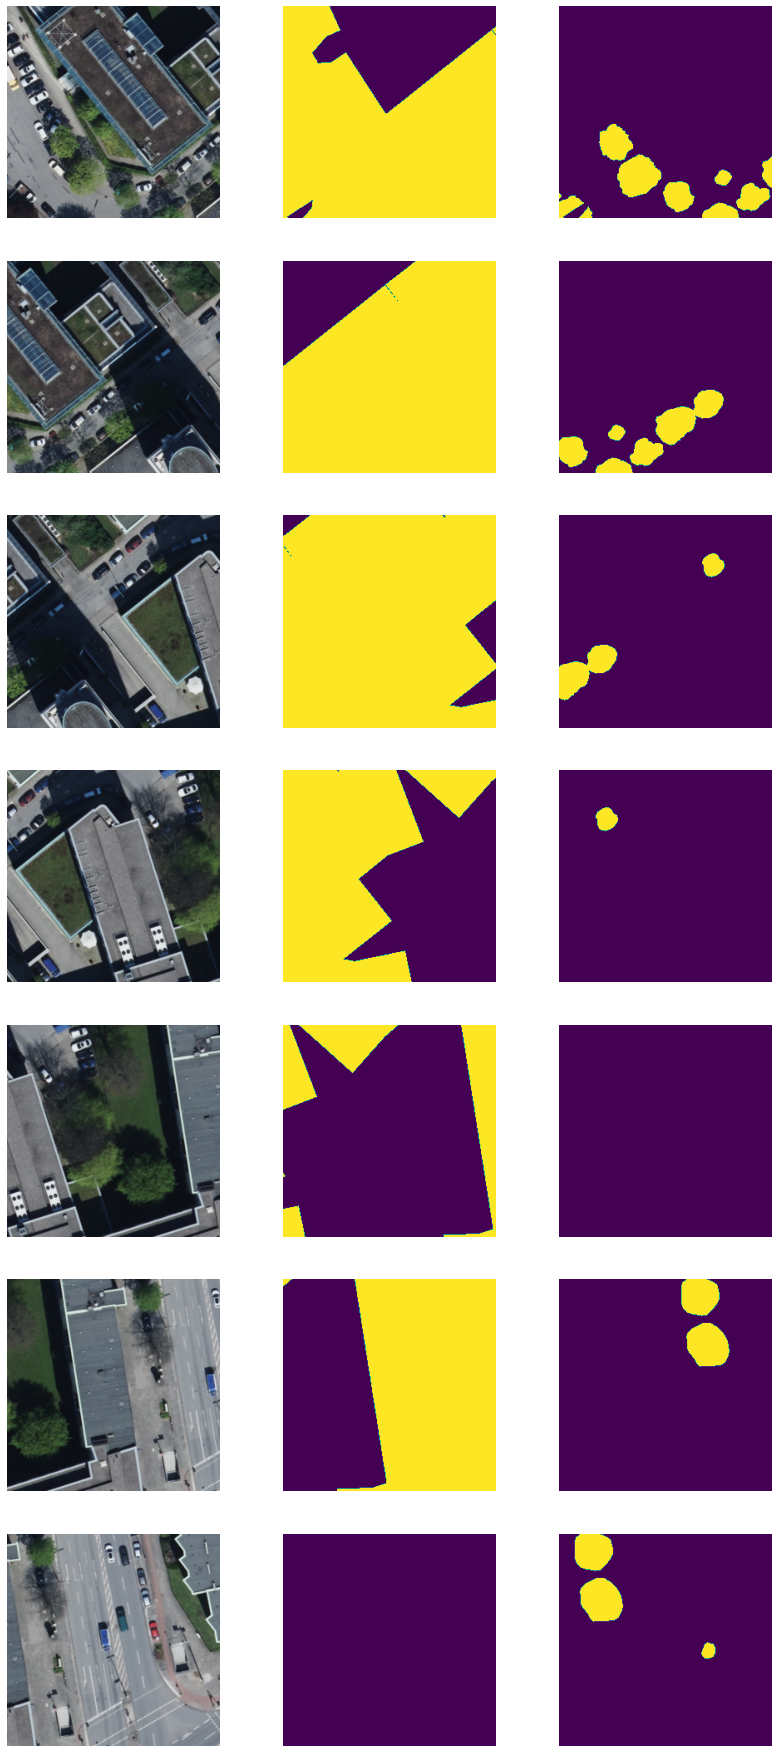

In [24]:
st = 30
end = 37
display_images( np.concatenate((allPatches[0][st:end], allPatches[1][st:end]), axis = -1))

In [12]:
from keras import models, layers
from keras import regularizers

def UNet(input_shape,input_label_channel, layer_count=64, regularizers = regularizers.l2(0.0001), weight_file = None):

        input_img = layers.Input(input_shape[1:], name='RGB_Input')
        pp_in_layer = input_img
        pp_in_layer = layers.BatchNormalization()(pp_in_layer)

        c1 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(pp_in_layer)
        c1 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(c1)
        n1 = layers.BatchNormalization()(c1)
        p1 = layers.MaxPooling2D((2, 2))(n1)

        c2 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(p1)
        c2 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(c2)
        n2 = layers.BatchNormalization()(c2)
        p2 = layers.MaxPooling2D((2, 2))(n2)

        c3 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(p2)
        c3 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(c3)
        n3 = layers.BatchNormalization()(c3)
        p3 = layers.MaxPooling2D((2, 2))(n3)

        c4 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(p3)
        c4 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(c4)
        n4 = layers.BatchNormalization()(c4)
        p4 = layers.MaxPooling2D(pool_size=(2, 2))(n4)        
        c5 = layers.Conv2D(16*layer_count, (3, 3), activation='relu', padding='same')(p4)
        c5 = layers.Conv2D(16*layer_count, (3, 3), activation='relu', padding='same')(c5)

        u6 = layers.UpSampling2D((2, 2))(c5)
        n6 = layers.BatchNormalization()(u6)
        u6 = layers.concatenate([n6, n4])
        c6 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(u6)
        c6 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(c6)

        u7 = layers.UpSampling2D((2, 2))(c6)
        n7 = layers.BatchNormalization()(u7)
        u7 = layers.concatenate([n7, n3])
        c7 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(u7)
        c7 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(c7)

        u8 = layers.UpSampling2D((2, 2))(c7)
        n8 = layers.BatchNormalization()(u8)
        u8 = layers.concatenate([n8, n2])
        c8 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(u8)
        c8 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(c8)

        u9 = layers.UpSampling2D((2, 2))(c8)
        n9 = layers.BatchNormalization()(u9)
        u9 = layers.concatenate([n9, n1], axis=3)
        c9 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(u9)
        c9 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(c9)

        d = layers.Conv2D(len(input_label_channel), (1, 1), activation='sigmoid', kernel_regularizer= regularizers)(c9)

        seg_model = models.Model(inputs=[input_img], outputs=[d])
        if weight_file:
            seg_model.load_weights(weight_file)
#         seg_model.summary()
        return seg_model

In [13]:
import keras.backend as K

def tversky_loss(y_true, y_pred, alpha=0.3, beta=0.7):
    #     print(K.shape(y_true))
    ones = K.ones(K.shape(y_true))
    p0 = y_pred  # proba that voxels are class i
    p1 = ones - y_pred  # proba that voxels are not class i
    g0 = y_true
    g1 = ones - y_true

    num = K.sum(p0 * g0, (0, 1, 2))
    den = num + alpha * K.sum(p0 * g1, (0, 1, 2)) + beta * K.sum(p1 * g0, (0, 1, 2))

    T = K.sum(num / den)  # when summing over classes, T has dynamic range [0 Ncl]

    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl - T

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true) * K.flatten(K.round(y_pred))) / K.sum(y_true)

def accuracy(y_true, y_pred):
    return K.equal(K.round(y_true), K.round(y_pred))

In [14]:
model = UNet([BATCH_SIZE, *input_shape], label_channels, layer_count=64)

# To load an existing model for further training.
# existing_model_path= './saved_models/UNet/nonAug/sahara_20191208-1851_adam_Tversky_loss_012_128.h5'
# model = load_model(existing_model_path, custom_objects={'tversky_loss': tversky_loss,'jaccard_distance_loss':jaccard_distance_loss, 'dice_coef': dice_coef, 'dice_loss':dice_loss, 'true_positive_rate':true_positive_rate, 'accuracy':accuracy})


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 4)  16          RGB_Input[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 2368        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
___________________________________________________________________________________________

In [15]:
# if separate_edge_class:
# #     wl = weighted_binary_crossentropy(10)
#     model.compile(optimizer=OPTIMIZER, loss=tversky_loss, metrics=[tversky_radio_loss, jaccard_distance_loss, dice_coef_ori, dice_loss, 'binary_accuracy', true_positive_rate, sensitivity, accuracy, false_negative_rate])
# else: 
LOSS = tversky_loss
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[true_positive_rate, accuracy])

In [16]:
# Define callbacks for the early stopping of training, LearningRateScheduler and model checkpointing

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=4, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=4, min_lr=1e-16)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=7) #With the increased batch size, patience can be reduced 

log_dir = os.path.join('./logs','UNet_{}_{}_{}_{}_{}'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs, input_shape[0]))
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=BATCH_SIZE, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_list = [checkpoint, early, tensorboard] #reduceLROnPlat is not required with adaDelta

In [17]:
# Train the model!!!
loss_history = [model.fit(x = allPatches[0][training_patches], 
                    y = allPatches[1][training_patches],
                    batch_size = 8,
                    validation_data = (allPatches[0][validation_patches], allPatches[1][validation_patches]),
                    epochs=NB_EPOCHS, 
                    callbacks=callbacks_list,
#                     use_multiprocessing=True,
#                     workers=1 # the generator is not very thread safe,
                    )]


Train on 1848 samples, validate on 462 samples


Epoch 1/100
1848/1848 [==============================] - 1596s 863ms/step - loss: -0.1509 - true_positive_rate: 0.9694 - accuracy: 0.6959 - val_loss: 0.9735 - val_true_positive_rate: 0.0000e+00 - val_accuracy: 0.9271

Epoch 00001: val_loss improved from inf to 0.97347, saving model to ./saved_models/UNet/hamburg_20200512-0934_adam_Tversky_loss_01234_256.h5

Epoch 2/100
1848/1848 [==============================] - 1599s 865ms/step - loss: -0.1934 - true_positive_rate: 0.9651 - accuracy: 0.7596 - val_loss: -0.1522 - val_true_positive_rate: 0.9494 - val_accuracy: 0.7625

Epoch 00002: val_loss improved from 0.97347 to -0.15216, saving model to ./saved_models/UNet/hamburg_20200512-0934_adam_Tversky_loss_01234_256.h5
Epoch 3/100
1848/1848 [==============================] - 1598s 865ms/step - loss: -0.2168 - true_positive_rate: 0.9699 - accuracy: 0.7833 - val_loss: -0.2063 - val_true_positive_rate: 0.9717 - val_accuracy: 0.7905

Epoch 00003: v

KeyboardInterrupt: 

In [26]:
# Once the model is fully trained, load the model that had the best performace (which may not come from the last epoch).

# optimizer=OPTIMIZER, loss=LOSS, metrics=[true_positive_rate, accuracy]
model = load_model(model_path, custom_objects={'loss_function': tversky_loss, 'true_positive_rate': true_positive_rate, 'accuracy':accuracy}, compile=False)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[true_positive_rate, accuracy])

In [28]:
# Evaluate the model!

ev = model.evaluate(allPatches[0][testing_patches], allPatches[1][testing_patches], batch_size=4)
r  = dict(zip(model.metrics_names, ev))
print(r)

578/578 [==============================] - 120s 207ms/step
{'loss': -0.2149482525008566, 'true_positive_rate': nan, 'accuracy': 0.7840216159820557}


# Generate predictions for 15 samples


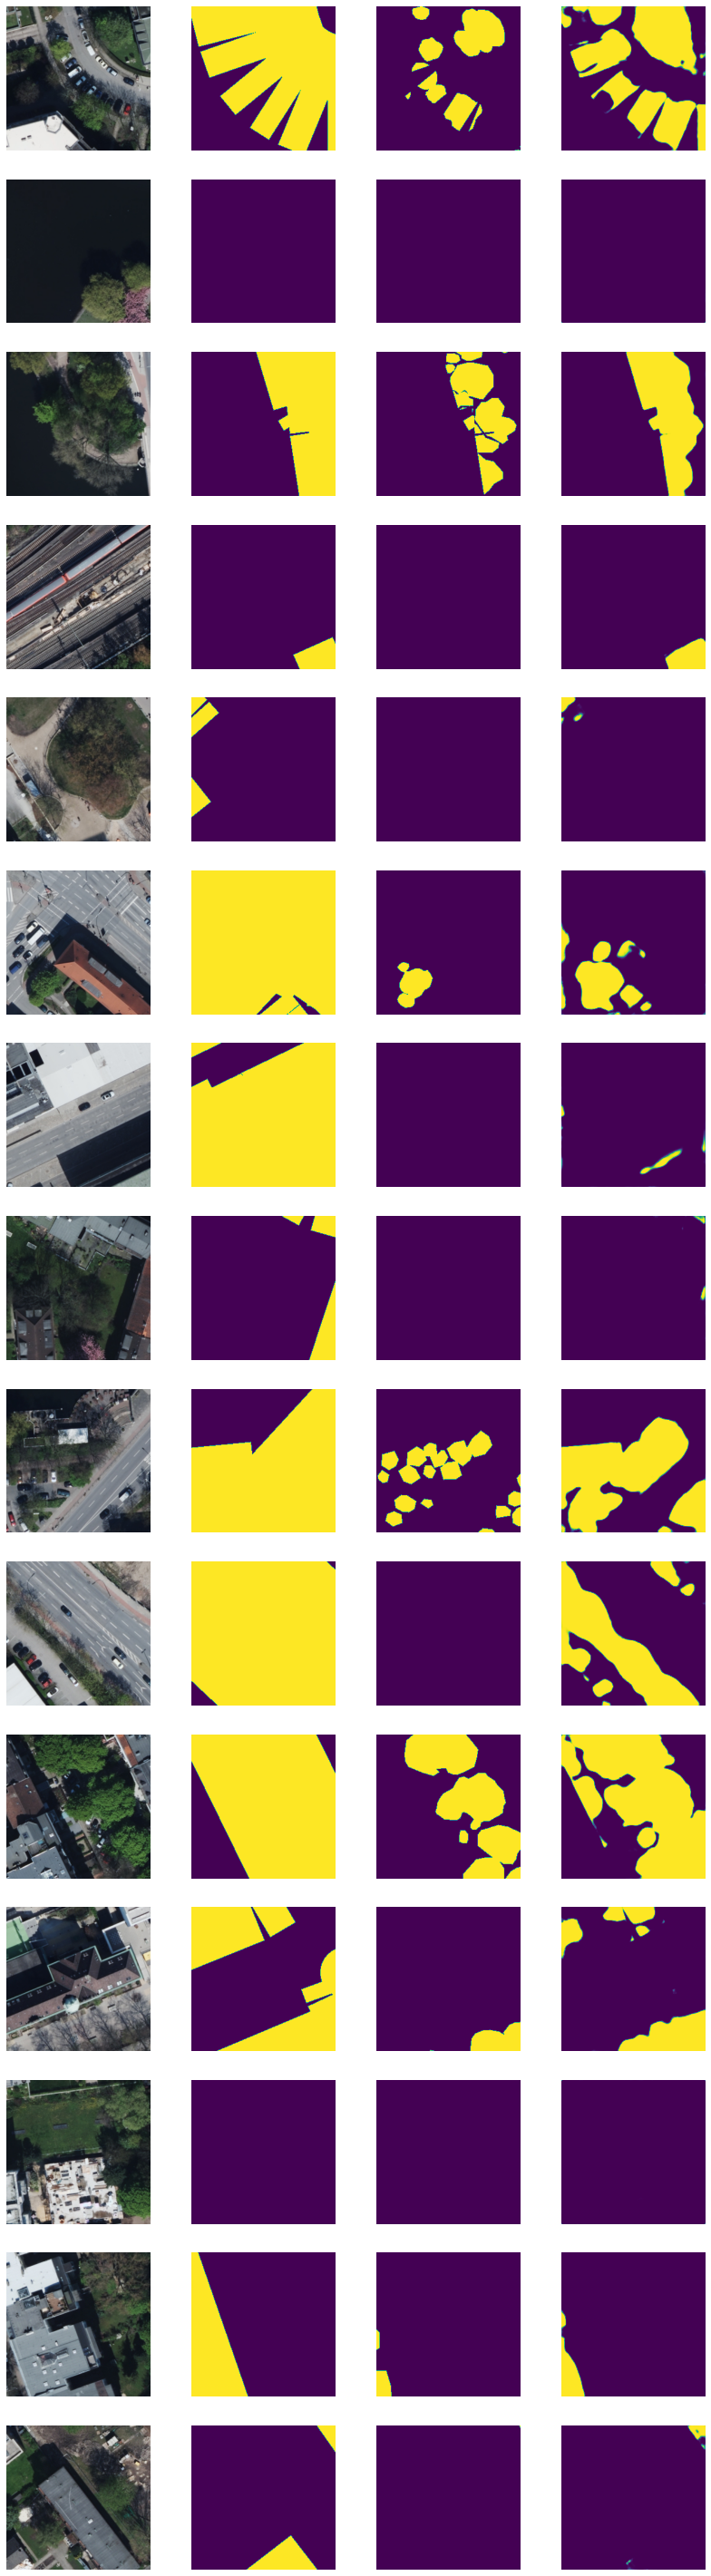

In [35]:
st = 105
end = 120
print(f'# Generate predictions for {end-st} samples')
predictions = model.predict(allPatches[0][testing_patches[st:end]])
display_images( np.concatenate((allPatches[0][testing_patches[st:end]], allPatches[1][testing_patches[st:end]], predictions), axis = -1), cols=4)